In [1]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd

mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
# 调用GPU加速
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

[]


In [2]:
#（1）读取数据集
filepath = './data/jena_climate_2009_2016.csv'
df = pd.read_csv(filepath)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [3]:
TRAIN_SPLIT = 300000
# 设置种子以确保可重复性。
tf.random.set_seed(13)

In [4]:
features_considered = ['T (degC)', 'rh (%)']
features = df[features_considered]
features.index = df['Date Time']
features.head()


,T (degC),rh (%)
Date Time,,
01.01.2009 00:10:00,-8.02,93.3
01.01.2009 00:20:00,-8.41,93.4
01.01.2009 00:30:00,-8.51,93.9
01.01.2009 00:40:00,-8.31,94.2
01.01.2009 00:50:00,-8.27,94.1


array([<AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>],
      dtype=object)

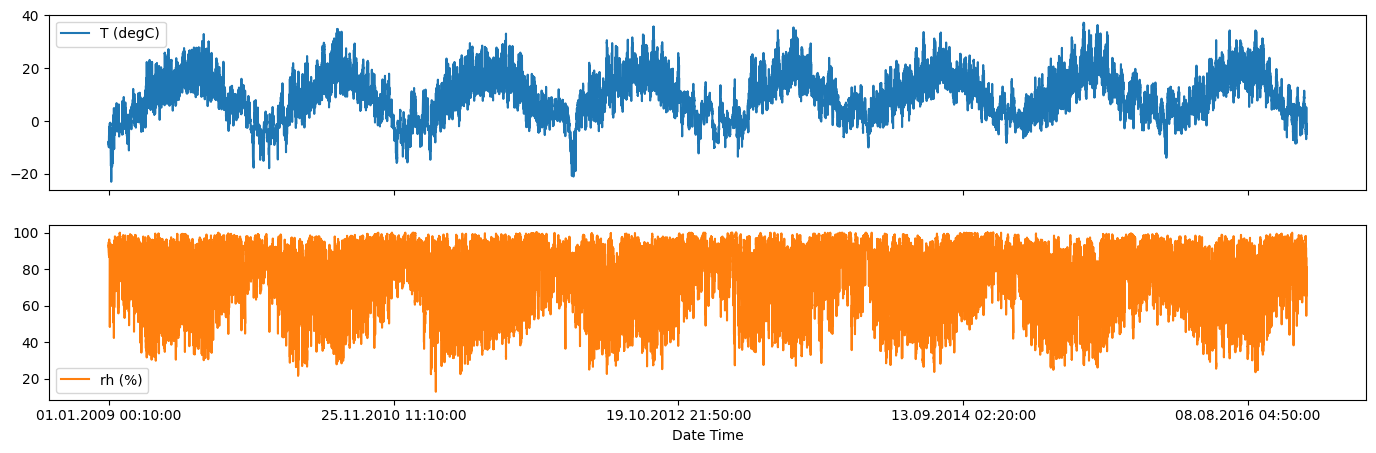

In [5]:
features.plot(subplots=True)

In [6]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

In [ ]:
past_history = 6
future_target = 6
STEP = 1
def create_time_steps(length):
    return list(range(-length, 0))

def multivariate_multioutput_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data)[:,:,:,np.newaxis,np.newaxis], np.array(labels)[:,:,:,np.newaxis,np.newaxis]

def multi_step_output_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    print(np.arange(num_out)/STEP)
    for i, (var, c) in enumerate(zip(features.columns[:2], ['b','r'])):
        plt.plot(num_in, np.array(history[:, i]), c, label=var)
        plt.plot(np.arange(num_out)/STEP, np.array(true_future[:,i]), c+'o', markersize=5, alpha=0.5,
               label=f"True {var.title()}")
        if prediction.any():
            print(np.array(prediction[:,i]))
            plt.plot(np.arange(num_out)/STEP, np.array(prediction[:,i]), '*', markersize=5, alpha=0.5,
                     label=f"Predicted {var.title()}")

    plt.legend(loc='upper left')
    plt.show()

In [ ]:
x_train_multi, y_train_multi = multivariate_multioutput_data(dataset[:,], dataset[:,], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_multioutput_data(dataset[:,], dataset[:,],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)


In [ ]:
print (x_train_multi.shape,
       y_train_multi.shape,
       x_val_multi.shape,
       y_val_multi.shape,
       'Single window of past history : {}'.format(x_train_multi[0].shape),
       'Target temperature to predict : {}'.format(y_train_multi[0].shape),
       sep='\n')

In [10]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000
learning_rate = 0.0001
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

(6, 2, 1, 1)
(1, 6, 2, 1, 1)
(1,)
[0. 1. 2. 3. 4. 5.]


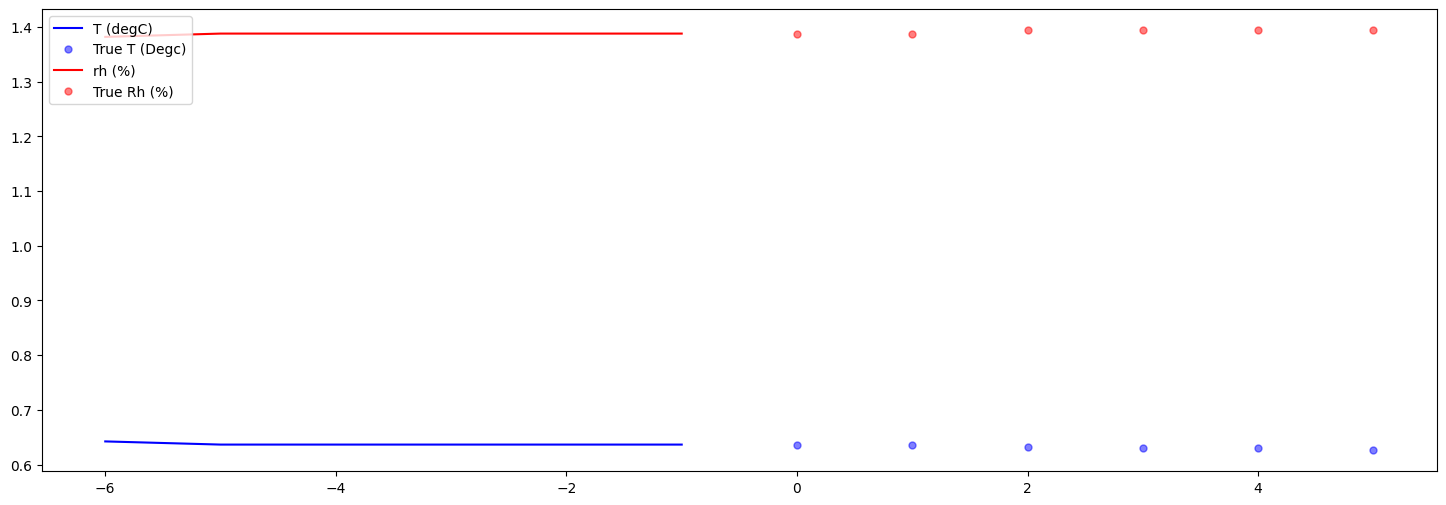

In [11]:
for x, y in val_data_multi.take(1):
    # print(x[0])
    print(x[0].shape)
    print(x[0][np.newaxis,:,:,:,:].shape)
    print(np.array([0]).shape)
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.array([0]))

In [14]:
def build_model(input_timesteps, output_timesteps, num_links, num_inputs):
    # COPY PASTA
    # https://github.com/niklascp/bus-arrival-convlstm/blob/master/jupyter/ConvLSTM_3x15min_10x64-5x64-10x64-5x64-Comparison.ipynb

    model = Sequential()
    model.add(BatchNormalization(name = 'batch_norm_0', input_shape = (input_timesteps, num_inputs, 1, 1)))
    model.add(ConvLSTM2D(name ='conv_lstm_1',
                         filters = 64, kernel_size = (10, 1),
                         padding = 'same',
                         return_sequences = True))

    model.add(Dropout(0.30, name = 'dropout_1'))
    model.add(BatchNormalization(name = 'batch_norm_1'))

    model.add(ConvLSTM2D(name ='conv_lstm_2',
                         filters = 64, kernel_size = (5, 1),
                         padding='same',
                         return_sequences = False))

    model.add(Dropout(0.20, name = 'dropout_2'))
    model.add(BatchNormalization(name = 'batch_norm_2'))

    model.add(Flatten())
    model.add(RepeatVector(output_timesteps))
    model.add(Reshape((output_timesteps, num_inputs, 1, 64)))

    model.add(ConvLSTM2D(name ='conv_lstm_3',
                         filters = 64, kernel_size = (10, 1),
                         padding='same',
                         return_sequences = True))

    model.add(Dropout(0.20, name = 'dropout_3'))
    model.add(BatchNormalization(name = 'batch_norm_3'))

    model.add(ConvLSTM2D(name ='conv_lstm_4',
                         filters = 64, kernel_size = (5, 1),
                         padding='same',
                         return_sequences = True))

    model.add(TimeDistributed(Dense(units=1, name = 'dense_1', activation = 'relu')))
    model.add(Dense(units=1, name = 'dense_2', activation = 'linear'))

#     optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
#     optimizer = tf.keras.optimizers.Adam(0.1)
    optimizer = tf.keras.optimizers.RMSprop(lr=0.004, clipvalue=1.0)
    model.compile(loss = "mse", optimizer = optimizer, metrics = ['mae', 'mse'])
    return model

In [21]:
EPOCHS = 20
steps_per_epoch = 400
validation_steps = 100

modelstart = time.time()
# early_stopping = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights=True)
model = build_model(x_train_multi.shape[1], future_target, y_train_multi.shape[2], x_train_multi.shape[2])
print(model.summary())

path_checkpoint = "./model/multi_weather_multi_LSTM2.h5"
modelckpt_callback = ModelCheckpoint(
    filepath=path_checkpoint,
    verbose=1,
    save_best_only=True,
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 6, 2, 1, 1)        4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 6, 2, 1, 64)       166656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 2, 1, 64)       0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 6, 2, 1, 64)       256       
_________________________________________________________________
conv_lstm_2 (ConvLSTM2D)     (None, 2, 1, 64)          164096    
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 1, 64)          0         
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 2, 1, 64)         

In [ ]:
# Train
print("\nTRAIN MODEL...")
history = model.fit(train_data_multi,
                    epochs = EPOCHS,
                    validation_data=val_data_multi,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    verbose=1,
                    callbacks=[modelckpt_callback])
print("\nModel Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))


TRAIN MODEL...
Epoch 1/20
400/400 [==============================] - ETA: 0s - loss: 0.2887 - mae: 0.3362 - mse: 0.2887
Epoch 00001: val_loss improved from inf to 0.27118, saving model to ./model\multi_weather_multi_LSTM2.h5
400/400 [==============================] - 105s 263ms/step - loss: 0.2887 - mae: 0.3362 - mse: 0.2887 - val_loss: 0.2712 - val_mae: 0.4437 - val_mse: 0.2712
Epoch 2/20
400/400 [==============================] - ETA: 0s - loss: 0.0598 - mae: 0.1621 - mse: 0.0598
Epoch 00002: val_loss improved from 0.27118 to 0.04659, saving model to ./model\multi_weather_multi_LSTM2.h5
400/400 [==============================] - 104s 261ms/step - loss: 0.0598 - mae: 0.1621 - mse: 0.0598 - val_loss: 0.0466 - val_mae: 0.1894 - val_mse: 0.0466
Epoch 3/20
400/400 [==============================] - ETA: 0s - loss: 0.0345 - mae: 0.1302 - mse: 0.0345
Epoch 00003: val_loss did not improve from 0.04659
400/400 [==============================] - 106s 265ms/step - loss: 0.0345 - mae: 0.1302 - 

In [24]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

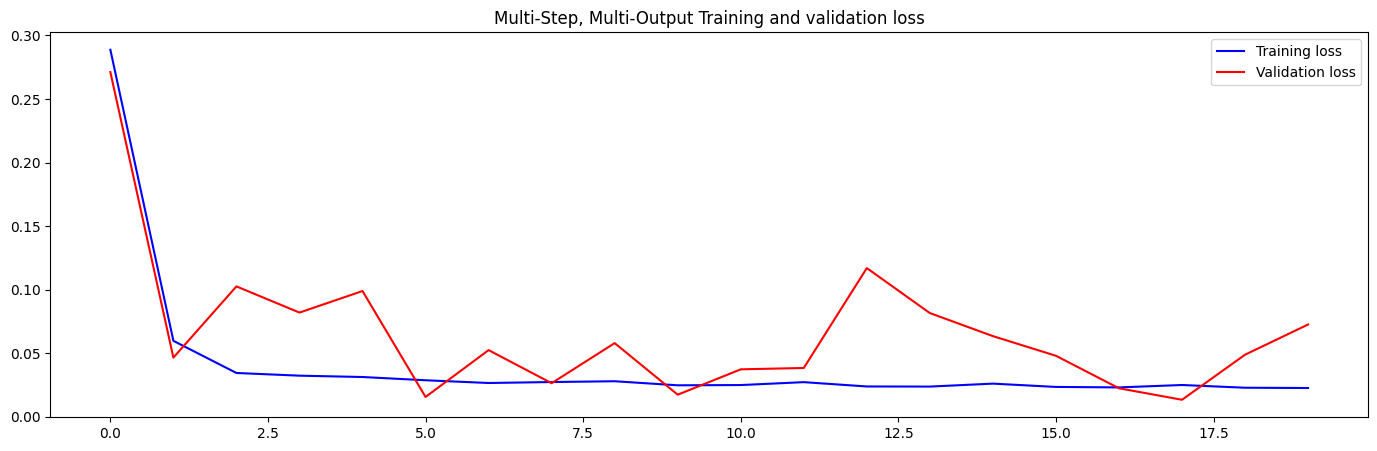

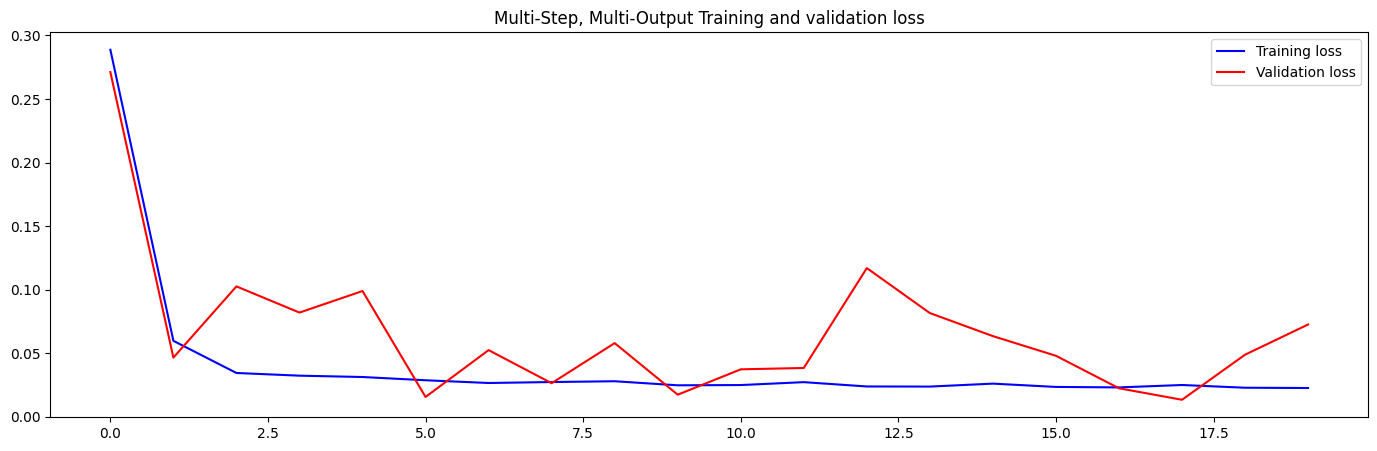

In [26]:
plot_train_history(history, 'Multi-Step, Multi-Output Training and validation loss')

In [12]:
# load the checkpoint
checkpoint = tf.keras.models.load_model('./model/best_cnnLSTM.h5')
checkpoint.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_norm_0 (BatchNormaliza (None, 6, 2, 1, 1)        4         
_________________________________________________________________
conv_lstm_1 (ConvLSTM2D)     (None, 6, 2, 1, 64)       166656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 2, 1, 64)       0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 6, 2, 1, 64)       256       
_________________________________________________________________
conv_lstm_2 (ConvLSTM2D)     (None, 2, 1, 64)          164096    
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 1, 64)          0         
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 2, 1, 64)         

(1, 6, 2, 1, 1)
(1, 6, 2, 1, 1)
(6, 2)
[0. 1. 2. 3. 4. 5.]
[0.5770614  0.55641747 0.5606618  0.5705371  0.57651377 0.5789285 ]
[1.3221524 1.3150342 1.3461902 1.3403239 1.3287921 1.31773  ]


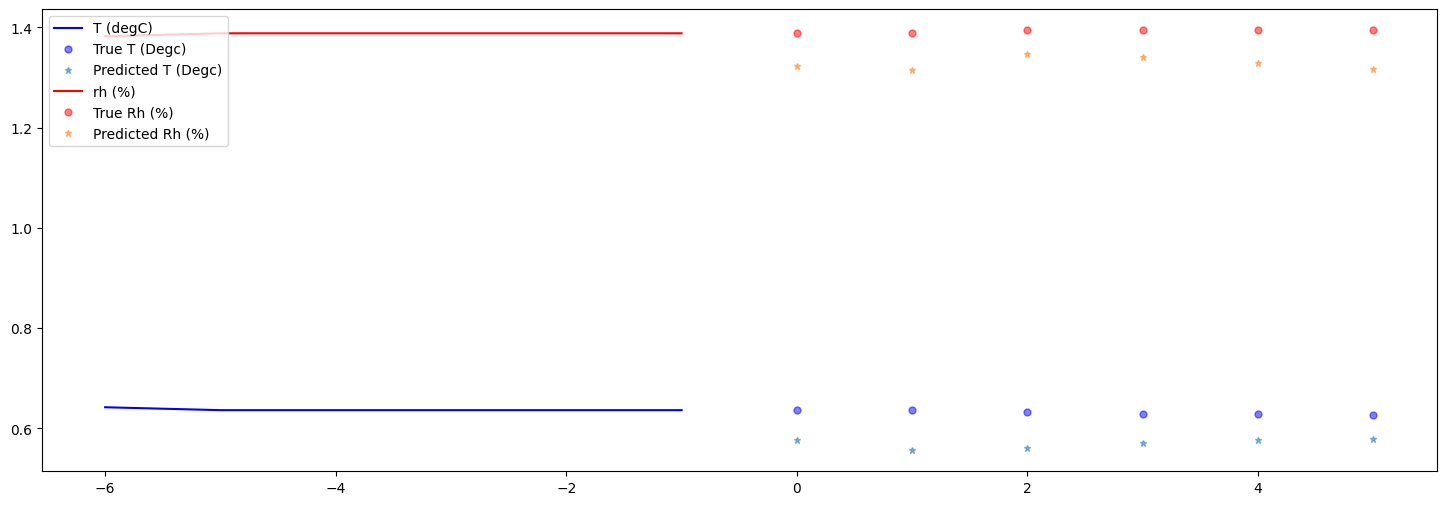

In [14]:
for x, y in val_data_multi.take(1):
    # print(x[0].shape)
    print(x[0][np.newaxis,:,:,:,:].shape)
    r = checkpoint.predict(x[0][np.newaxis,:,:,:,:])
    print(r.shape)
    res = np.squeeze(r)
    print(res.shape)
    multi_step_output_plot(np.squeeze(x[0]), np.squeeze(y[0]), np.squeeze(model.predict(x[0][np.newaxis,:,:,:,:])))